# 3. ZenML Pipeline: Embedding & FAISS
### - **Below is the three steps:**

- **1. fetch_contexts** → loads your contexts from MongoDB (or from a CSV).

- **2. generate_embeddings** → uses a Sentence Transformers model to produce vectors.

- **3. build_faiss_index** → constructs and saves the index to disk.

In [1]:
"""
ZenML pipeline that:
1. Fetches context passages (and optionally questions) from MongoDB or CSV.
2. Generates embeddings with a HuggingFace model.
3. Builds a FAISS index and saves it to disk.

We'll store references to each context so we can map FAISS IDs -> actual text.
"""

import os
import numpy as np
import pandas as pd
from typing import Tuple, List, Any
from zenml.pipelines import pipeline
from zenml.steps import step
from sentence_transformers import SentenceTransformer
import faiss

PyTorch version 2.6.0 available.
Loading faiss.
Successfully loaded faiss.
Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.


In [2]:
import os
import subprocess
from pymongo import MongoClient


def ensure_mongodb_running():
    """Checks if MongoDB is running, and starts it if not."""
    try:
        # Try connecting to MongoDB
        subprocess.run(["mongosh", "--eval", "db.runCommand({ ping: 1 })"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
        print("✅ MongoDB is already running.")
    except subprocess.CalledProcessError:
        print("⚠️ MongoDB is NOT running. Attempting to start it...")
        os.system("brew services start mongodb-community")
        print("✅ MongoDB is running now!!!")


def get_mongo_connection(mongo_uri:str = "mongodb://localhost:27017/", db_name:str = "medimaven_db"):
    client = MongoClient(mongo_uri)
    db = client[db_name]

    return db

In [3]:
src_collection = 'qa_master_processed'

In [4]:
ensure_mongodb_running()

✅ MongoDB is already running.


In [5]:
db = get_mongo_connection()
collection = db[src_collection]

In [6]:
data = list(collection.find({},{'_id' : 0}))
df = pd.DataFrame(data)
df


,Dataset,focus,synonyms,qtype,question,context,answer,speciality,tags,created_at,updated_at,context_length
0,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",information,"What is are T cell immunodeficiency, congenita...","alymphoid cystic thymic dysgenesis,congenital ...","T cell immunodeficiency, congenital alopecia, ...",,[],2025-03-04 23:55:05.644,2025-03-04 23:55:05.644,324
1,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",frequency,How many people are affected by T cell immunod...,"alymphoid cystic thymic dysgenesis,congenital ...","T cell immunodeficiency, congenital alopecia, ...",,[],2025-03-04 23:55:05.644,2025-03-04 23:55:05.644,344
2,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",genetic changes,What are the genetic changes related to T cell...,"alymphoid cystic thymic dysgenesis,congenital ...","T cell immunodeficiency, congenital alopecia, ...",,[],2025-03-04 23:55:05.644,2025-03-04 23:55:05.644,352
3,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",inheritance,"Is T cell immunodeficiency, congenital alopeci...","alymphoid cystic thymic dysgenesis,congenital ...",This condition is inherited in an autosomal re...,,[],2025-03-04 23:55:05.644,2025-03-04 23:55:05.644,325
4,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",treatment,What are the treatments for T cell immunodefic...,"alymphoid cystic thymic dysgenesis,congenital ...",These resources address the diagnosis or manag...,,[],2025-03-04 23:55:05.644,2025-03-04 23:55:05.644,340
...,...,...,...,...,...,...,...,...,...,...,...,...
52006,iCliniQ,,,,I am not gaining weight. Please guide me if I ...,"Hi doctor,\nI am 24 years old male. For the pa...","Hello,Welcome to icliniq.com.First of all, che...",Neurology,[],2025-03-04 23:55:05.662,2025-03-04 23:55:05.662,401
52007,iCliniQ,,,,Do I need treatment for premature ejaculation?,"Hello doctor,\nI am 37 years old, a gynecologi...","Hello,\nWelcome to icliniq.com.\nNo, it is not...",Cardiology,[],2025-03-04 23:55:05.662,2025-03-04 23:55:05.662,600
52008,iCliniQ,,,,I had unprotected sex. What are my chances of ...,"Hello doctor,\nI had unprotected sex with my b...","Hi,\nWelcome to icliniq.com.\nPlease do not be...",Obstetrics and Gynecology,[],2025-03-04 23:55:05.662,2025-03-04 23:55:05.662,653
52009,iCliniQ,,,,How many days after HIV do rashes appear?,"Hello doctor,\n15 days back, I met a girl and ...","Hello,\nWelcome to icliniq.com. A rash is a ve...",Dermatology,[],2025-03-04 23:55:05.662,2025-03-04 23:55:05.662,1221


In [7]:
df.shape

(52011, 12)

In [8]:
# We assume 'context' is the main text field you want to embed.
# And generate a 'context_id'.
if "context_id" not in df.columns:
    df["context_id"] = df.index.astype(str) 


# Drop duplicates if necessary
df = df.drop_duplicates(subset=["context"]).reset_index(drop=True)
df.shape



(51973, 13)

In [9]:
df.shape[0]

51973

In [19]:
j = 'context'

In [21]:
cid = j+'_id'

df[[cid]]

,context_id
0,0
1,1
2,2
3,3
4,4
...,...
51968,52006
51969,52007
51970,52008
51971,52009


In [13]:
# Return only relevant columns
df_rel =  df[["context_id", "context"]]

In [11]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
batch_size = 32


In [153]:
model = SentenceTransformer(model_name)

Use pytorch device_name: mps
Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


In [32]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [ ]:
model.

256

In [35]:
model.encode('i want to eat').shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(384,)

In [36]:
model.encode('i want to eat')[:5]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([-0.03537161,  0.01238951, -0.04713919,  0.04910793, -0.10635508],
      dtype=float32)

In [37]:
contexts = df_rel["context"].to_list()
embeddings = model.encode(contexts, batch_size=batch_size, show_progress_bar=True)
embeddings = np.array(embeddings).astype("float32")

Batches:   0%|          | 0/1625 [00:00<?, ?it/s]

In [38]:
embeddings.shape

(51973, 384)

In [12]:
from transformers import AutoTokenizer

def chunk_text_by_tokens(text: str, tokenizer, max_tokens=384, overlap=50):
    encoded = tokenizer.encode(text)
    chunks = []
    start = 0
    while start < len(encoded):
        end = start + max_tokens
        chunk_ids = encoded[start:end]
        chunk_text = tokenizer.decode(chunk_ids, skip_special_tokens=True)
        chunks.append(chunk_text)
        start += (max_tokens - overlap)
    return chunks


def chunk_and_prepare(df: pd.DataFrame, model_name: str = "sentence-transformers/all-mpnet-base-v2") -> pd.DataFrame:
    from transformers import AutoTokenizer
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    all_rows = []
    for _, row in df.iterrows():
        original_text = row["context"]
        chunked_texts = chunk_text_by_tokens(original_text, tokenizer, max_tokens=512, overlap=50)
        for idx, chunk in enumerate(chunked_texts):
            new_row = row.copy()
            new_row["context"] = chunk
            new_row["chunk_id"] = f"{row['context_id']}_{idx}"
            all_rows.append(new_row)
    
    return pd.DataFrame(all_rows)

In [107]:
tok = AutoTokenizer.from_pretrained(model_name)
tok

BertTokenizerFast(name_or_path='sentence-transformers/all-MiniLM-L6-v2', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [104]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
all_rows = []
for _, row in df_rel.iterrows():
    original_text = row["context"]
    # print(len(original_text.split()))

    if len(original_text.split()) > 512:
        print(len(original_text.split()))
        chunked_texts = chunk_text_by_tokens(original_text, tokenizer, max_tokens=512, overlap=50)
        # print(chunked_texts)
        for idx, chunk in enumerate(chunked_texts):
            print(chunk)

            new_row = row.copy()
            new_row["context"] = chunk
            new_row["chunk_id"] = f"{row['context_id']}_{idx}"
            all_rows.append(new_row)
            
        break

temp_df = pd.DataFrame(all_rows)

Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors


594
text len:  594
enc len:  711
asperger syndrome is a developmental disorder that affects a person s ability to interact with others, understand the world, and behave. hello doctor, i am a 30 year old male. i am not under any medications. i tried lymecycline a couple of years ago and multiple creams for acne in the past. i have a history of mental health problems. i have a diagnosis of asperger syndrome, ocd, anxiety, and depression. my anxiety levels have been chronic for many years due to the severity of my obsessive thoughts and compulsions etc. i think that my poor mental state has impacted on my health. i have had severe skin problems since i was about 17 or so. i get huge cysts that often recur in the same place with large boils. i have some large permanent cysts. i seem to break out at certain times. i also have a condition known as a functional neurological disorder. i will be seeing a neurologist here at a movement disorders clinic to deal with this in the near future. i als

In [81]:
temp_df.iloc[0]['context']

'asperger syndrome is a developmental disorder that affects a person s ability to interact with others, understand the world, and behave. hello doctor, i am a 30 year old male. i am not under any medications. i tried lymecycline a couple of years ago and multiple creams for acne in the past. i have a history of mental health problems. i have a diagnosis of asperger syndrome, ocd, anxiety, and depression. my anxiety levels have been chronic for many years due to the severity of my obsessive thoughts and compulsions etc. i think that my poor mental state has impacted on my health. i have had severe skin problems since i was about 17 or so. i get huge cysts that often recur in the same place with large boils. i have some large permanent cysts. i seem to break out at certain times. i also have a condition known as a functional neurological disorder. i will be seeing a neurologist here at a movement disorders clinic to deal with this in the near future. i also developed eyelash ptosis, wher

In [88]:
temp_df['context']

4375    asperger syndrome is a developmental disorder ...
4375    nail infections on my toes or my athlete s foo...
Name: context, dtype: object

In [94]:
enc = model.encode(temp_df['context'].to_list()[0])
enc.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(384,)

In [ ]:
model.tokenizer

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 model.tokenizer.decode(enc)                                                                  │
│   2                                                                                              │
│                                                                                                  │
│ /opt/homebrew/Caskroom/miniconda/base/envs/MediMaven/lib/python3.12/site-packages/transformers/t │
│ okenization_utils_base.py:3860 in decode                                                         │
│                                                                                                  │
│   3857 │   │   # Convert inputs to python lists                                                  │
│   3858 │   │   token_ids = to_py_obj(token_ids)                                                  │
│   3859 │   │                                                                                     │
│ ❱ 3860 │   │   return self._decode(                                                              │
│   3861 │   │   │   token_ids=token_ids,                                                          │
│   3862 │   │   │   skip_special_tokens=skip_special_tokens,                                      │
│   3863 │   │   │   clean_up_tokenization_spaces=clean_up_tokenization_spaces,                    │
│                                                                                                  │
│ /opt/homebrew/Caskroom/miniconda/base/envs/MediMaven/lib/python3.12/site-packages/transformers/t │
│ okenization_utils_fast.py:668 in _decode                                                         │
│                                                                                                  │
│   665 │   │                                                                                      │
│   666 │   │   if isinstance(token_ids, int):                                                     │
│   667 │   │   │   token_ids = [token_ids]                                                        │
│ ❱ 668 │   │   text = self._tokenizer.decode(token_ids, skip_special_tokens=skip_special_tokens   │
│   669 │   │                                                                                      │
│   670 │   │   clean_up_tokenization_spaces = (                                                   │
│   671 │   │   │   clean_up_tokenization_spaces                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: argument 'ids': 'float' object cannot be interpreted as an integer

In [108]:
df_rel

,context_id,context
0,0,"alymphoid cystic thymic dysgenesis,congenital ..."
1,1,"alymphoid cystic thymic dysgenesis,congenital ..."
2,2,"alymphoid cystic thymic dysgenesis,congenital ..."
3,3,"alymphoid cystic thymic dysgenesis,congenital ..."
4,4,"alymphoid cystic thymic dysgenesis,congenital ..."
...,...,...
51968,52006,"Hi doctor,\nI am 24 years old male. For the pa..."
51969,52007,"Hello doctor,\nI am 37 years old, a gynecologi..."
51970,52008,"Hello doctor,\nI had unprotected sex with my b..."
51971,52009,"Hello doctor,\n15 days back, I met a girl and ..."


In [ ]:
all_rows = []
for _, row in df_rel.iterrows():
    original_text = row["context"]
    # print(len(original_text.split()))

    if len(original_text.split()) > 512:
        print(len(original_text.split()))
        chunked_texts = chunk_text_by_tokens(original_text, tokenizer, max_tokens=512, overlap=50)
        # print(chunked_texts)
        for idx, chunk in enumerate(chunked_texts):
            print(chunk)

            new_row = row.copy()
            new_row["context"] = chunk
            new_row["chunk_id"] = f"{row['context_id']}_{idx}"
            all_rows.append(new_row)
            
        break

temp_df = pd.DataFrame(all_rows)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
big_corps = []
all_rows = []
for _, row in df_rel.iterrows():
    original_text = row["context"]
    # print(len(original_text.split()))

    if len(original_text.split()) > 512:
        big_corps.append(original_text.split())
    chunked_texts = chunk_text_by_tokens(original_text, tokenizer, max_tokens=512, overlap=50)
    for idx, chunk in enumerate(chunked_texts):
        new_row = row.copy()
        new_row["context"] = chunk
        new_row["chunk_id"] = f"{row['context_id']}_{idx}"
        all_rows.append(new_row)    

chunk_df = pd.DataFrame(all_rows)

Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors


In [114]:
big_c = []
for _, row in df_rel.iterrows():
    original_text = row["context"]
    # print(len(original_text.split()))

    if len(original_text.split()) > 384:
        big_c.append(len(original_text.split()))

len(big_c)

669

In [117]:
np.median(big_c)

np.float64(469.0)

In [118]:
import matplotlib.pyplot as plt

(array([478., 124.,  39.,  16.,   4.,   5.,   2.,   0.,   0.,   1.]),
 array([ 385. ,  547.2,  709.4,  871.6, 1033.8, 1196. , 1358.2, 1520.4,
        1682.6, 1844.8, 2007. ]),
 <BarContainer object of 10 artists>)

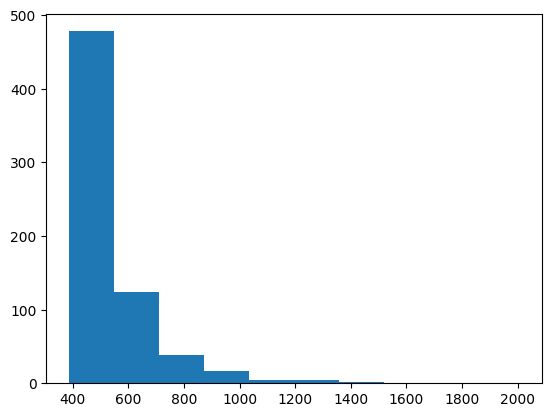

In [123]:
plt.hist(big_c)

In [121]:
len(big_c)

669

In [124]:
chunk_df

,context_id,context,chunk_id
0,0,"alymphoid cystic thymic dysgenesis, congenital...",0_0
1,1,"alymphoid cystic thymic dysgenesis, congenital...",1_0
2,2,"alymphoid cystic thymic dysgenesis, congenital...",2_0
3,3,"alymphoid cystic thymic dysgenesis, congenital...",3_0
4,4,"alymphoid cystic thymic dysgenesis, congenital...",4_0
...,...,...,...
51968,52006,"hi doctor, i am 24 years old male. for the pas...",52006_0
51969,52007,"hello doctor, i am 37 years old, a gynecologis...",52007_0
51970,52008,"hello doctor, i had unprotected sex with my bo...",52008_0
51971,52009,"hello doctor, 15 days back, i met a girl and w...",52009_0


In [126]:

model_name= "sentence-transformers/all-MiniLM-L6-v2"
batch_size= 32

"""
Step B: Use a Transformer model to embed each context passage.

:param df: DataFrame with "context_id" and "context".
:param model_name: Name of the Hugging Face / SentenceTransformer model.
:param batch_size: Batch size for encoding.
:return: (df, embeddings)
    df: the same DataFrame (for reference)
    embeddings: a numpy array of shape (num_contexts, embedding_dim).
"""
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(model_name)

contexts = chunk_df["context"].tolist()
embeddings = model.encode(contexts, batch_size=batch_size, show_progress_bar=True)
embeddings = np.array(embeddings).astype("float32")  # For FAISS, float32 is typical


Use pytorch device_name: mps
Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Batches:   0%|          | 0/1625 [00:00<?, ?it/s]

In [ ]:
model.hf

device(type='mps', index=0)

In [128]:
chunk_df.shape

(51973, 3)

In [129]:
embeddings.shape

(51973, 384)

In [138]:
import faiss

index_save_path: str = "../data/processed/faiss_index.bin"

In [131]:
num_vectors, embedding_dim = embeddings.shape

In [132]:
# 1. Create a FAISS index
# For small-medium data, a simple IndexFlatL2 is fine.
index = faiss.IndexFlatL2(embedding_dim)

In [133]:
# 2. Add embeddings to the index
index.add(embeddings)

In [139]:
# 3. Save index to disk
faiss.write_index(index, index_save_path)
print(f"✅ FAISS index (IndexFlatL2) saved to: {index_save_path}")

✅ FAISS index (IndexFlatL2) saved to: ../data/processed/faiss_index.bin


In [151]:

# 4. Also store a mapping from index ID -> context_id in a separate file
# so we can look up the actual text later.
# We'll store it as a CSV with two columns: [faiss_id, context_id]
# Here, faiss_id is just the row index in the data.
mapping_df = pd.DataFrame({
    "faiss_id": range(num_vectors),
    "context_id": df["context_id"].tolist()
    })
mapping_dict = mapping_df.to_dict(orient='records')
mapping_dict

[{'faiss_id': 0, 'context_id': '0'},
 {'faiss_id': 1, 'context_id': '1'},
 {'faiss_id': 2, 'context_id': '2'},
 {'faiss_id': 3, 'context_id': '3'},
 {'faiss_id': 4, 'context_id': '4'},
 {'faiss_id': 5, 'context_id': '5'},
 {'faiss_id': 6, 'context_id': '6'},
 {'faiss_id': 7, 'context_id': '7'},
 {'faiss_id': 8, 'context_id': '8'},
 {'faiss_id': 9, 'context_id': '9'},
 {'faiss_id': 10, 'context_id': '10'},
 {'faiss_id': 11, 'context_id': '11'},
 {'faiss_id': 12, 'context_id': '12'},
 {'faiss_id': 13, 'context_id': '13'},
 {'faiss_id': 14, 'context_id': '14'},
 {'faiss_id': 15, 'context_id': '15'},
 {'faiss_id': 16, 'context_id': '16'},
 {'faiss_id': 17, 'context_id': '17'},
 {'faiss_id': 18, 'context_id': '18'},
 {'faiss_id': 19, 'context_id': '19'},
 {'faiss_id': 20, 'context_id': '20'},
 {'faiss_id': 21, 'context_id': '21'},
 {'faiss_id': 22, 'context_id': '22'},
 {'faiss_id': 23, 'context_id': '23'},
 {'faiss_id': 24, 'context_id': '24'},
 {'faiss_id': 25, 'context_id': '25'},
 {'fai

In [146]:
import json

In [147]:
mapping_path = index_save_path.replace(".bin", "_mapping.json")
mapping_path

'../data/processed/faiss_index_mapping.json'

In [152]:

with open(mapping_path, 'w') as f:
    json.dump(mapping_dict, f)


In [1]:
df

NameError: name 'df' is not defined

In [22]:
import torch
torch.cuda.empty_cache() 

In [23]:
import gc
gc.collect() 

1264

In [20]:
import wandb

In [ ]:
wan